# EYE FOR BLIND
This notebook will be used to prepare the capstone project 'Eye for Blind'

Project Pipeline:

The major steps that you have to perform can be briefly summarised in the following four steps:

Data Acquisition and Understanding: Here, you need to load the data and understand the representation.
Data Preprocessing: In this step, you will process both images and captions to the desired format.
Train-Test Split: Combine both images and captions to create the train and test dataset.
Model Building: This is the stage where you will create your image captioning model by building Encoder, Attention and Decoder model.
Model Evaluation: Evaluate the models using greedy search and BLEU score

Create a deep learning model which can explain the contents of an image in the form of speech through caption generation with an attention mechanism on Flickr8K dataset.

This kind of model is a use-case for blind people so that they can understand any image with the help of speech. The caption generated through a CNN-RNN model will be converted to speech using a text to speech library. The model will convert the contents of an image and will provide the output in the form of audio

In [172]:
#Installing needed library
!pip install wordcloud

In [173]:
! pip install --upgrade pip

In [174]:
#Import all the required libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import collections, random, re
from collections import Counter
from PIL import Image
import glob
import imageio.v2 as imageio
import os
from tqdm import tqdm
import string
import time
from IPython import display
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import Input
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
# For model evaluation
from nltk.translate.bleu_score import sentence_bleu
#Ignore the warning
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

Let's read the dataset

In [175]:
pd.set_option('display.max_rows',8)

> Import flicker Dataset from kaggle

In [176]:
pip install kaggle

Note: you may need to restart the kernel to use updated packages.


In [7]:
#import kagglehub

# Download latest version
#path = kagglehub.dataset_download("https://www.kaggle.com/datasets/adityajn105/flickr8k/data")

#print("Path to dataset files:", path)

In [177]:
!pip install opendatasets

In [178]:
import opendatasets as od 
import pandas 
  
path=od.download("https://www.kaggle.com/datasets/adityajn105/flickr8k/data") 

Skipping, found downloaded files in "./flickr8k" (use force=True to force download)


## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create a dataframe which summarizes the image, path & captions as a dataframe

4.Create a list which contains all the captions & path

5.Visualise the top 30 occuring words in the captions



In [179]:
for dirname, _, filenames in os.walk("./flickr8k/"):
    
    for filename in filenames:
        
        print(os.path.join(dirname, filename))

./flickr8k/captions.txt
./flickr8k/Images/1000268201_693b08cb0e.jpg
./flickr8k/Images/1001773457_577c3a7d70.jpg
./flickr8k/Images/1002674143_1b742ab4b8.jpg
./flickr8k/Images/1003163366_44323f5815.jpg
./flickr8k/Images/1007129816_e794419615.jpg
./flickr8k/Images/1007320043_627395c3d8.jpg
./flickr8k/Images/1009434119_febe49276a.jpg
./flickr8k/Images/1012212859_01547e3f17.jpg
./flickr8k/Images/1015118661_980735411b.jpg
./flickr8k/Images/1015584366_dfcec3c85a.jpg
./flickr8k/Images/101654506_8eb26cfb60.jpg
./flickr8k/Images/101669240_b2d3e7f17b.jpg
./flickr8k/Images/1016887272_03199f49c4.jpg
./flickr8k/Images/1019077836_6fc9b15408.jpg
./flickr8k/Images/1019604187_d087bf9a5f.jpg
./flickr8k/Images/1020651753_06077ec457.jpg
./flickr8k/Images/1022454332_6af2c1449a.jpg
./flickr8k/Images/1022454428_b6b660a67b.jpg
./flickr8k/Images/1022975728_75515238d8.jpg
./flickr8k/Images/102351840_323e3de834.jpg
./flickr8k/Images/1024138940_f1fefbdce1.jpg
./flickr8k/Images/102455176_5f8ead62d5.jpg
./flickr8k/I

In [180]:
#Import the dataset and read the image into a seperate variable

images='./flickr8k/Images' #image_path

all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


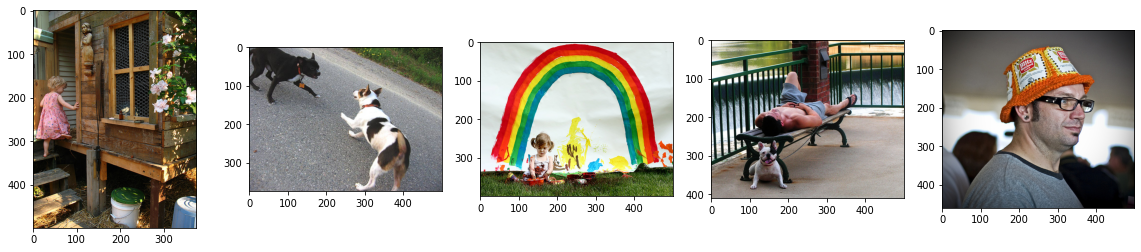

In [181]:
#Visualise both the images & text present in the dataset
figure, axes = plt.subplots(1,5)
figure.set_figwidth(20)

for ax,image in zip(axes, all_imgs[0:5]):
    img = Image.open(image)
    ax.imshow(img)

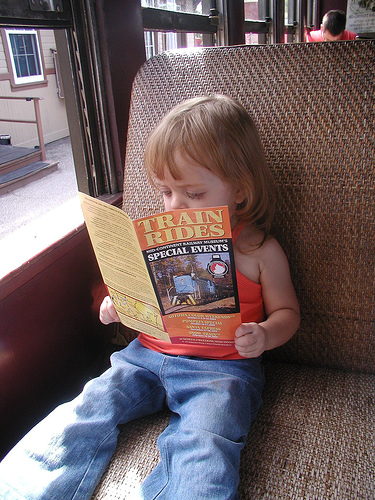

In [183]:
# let view random image
Image.open(all_imgs[random.randrange(40, 80, 3)])

In [184]:
#Import the dataset and read the text file into a seperate variable
text_file ='./flickr8k/captions.txt'
def load_doc(filename):
     with open(filename, 'r') as f:  # return an file obj.
        next(f) # It skips the header
        text = f.read()# read the content
     return text
doc = load_doc(text_file)
print(doc[:800])

1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .
1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .
1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .
1001773457_577c3a7d70.jpg,Tw


Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 4055 samples. i.e images * 5 = 5-caption for each image

In [185]:
imag_path='./flickr8k/Images/'

In [186]:
all_img_id = [] #store all the image id here
all_img_vector = [] #store all the image path here
annotations = [] #store all the captions here
with open(text_file , 'r') as f:
    next(f) # It skips the header
    for line in f :
        split_arr = line.split(',')
        all_img_id.append(split_arr[0])
        annotations.append(split_arr[1].rstrip('\n.'))
        all_img_vector.append(imag_path+split_arr[0])

df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions'])
df.shape
df.head(10)

ID                                         Path  \
0   1000268201_693b08cb0e.jpg  ./flickr8k/Images/1000268201_693b08cb0e.jpg   
1   1000268201_693b08cb0e.jpg  ./flickr8k/Images/1000268201_693b08cb0e.jpg   
2   1000268201_693b08cb0e.jpg  ./flickr8k/Images/1000268201_693b08cb0e.jpg   
3   1000268201_693b08cb0e.jpg  ./flickr8k/Images/1000268201_693b08cb0e.jpg   
..                        ...                                          ...   
6   1001773457_577c3a7d70.jpg  ./flickr8k/Images/1001773457_577c3a7d70.jpg   
7   1001773457_577c3a7d70.jpg  ./flickr8k/Images/1001773457_577c3a7d70.jpg   
8   1001773457_577c3a7d70.jpg  ./flickr8k/Images/1001773457_577c3a7d70.jpg   
9   1001773457_577c3a7d70.jpg  ./flickr8k/Images/1001773457_577c3a7d70.jpg   

                                             Captions  
0   A child in a pink dress is climbing up a set o...  
1                A girl going into a wooden building   
2     A little girl climbing into a wooden playhouse   
3   A little girl climbing the stairs to her playh...  
..                                                ...  
6   A black dog and a tri-colored dog playing with...  
7   A black dog and a white dog with brown spots a...  
8   Two dogs of different breeds looking at each o...  
9      Two dogs on pavement moving toward each other   

[10 rows x 3 columns]

In [187]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40455 entries, 0 to 40454
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        40455 non-null  object
 1   Path      40455 non-null  object
 2   Captions  40455 non-null  object
dtypes: object(3)
memory usage: 948.3+ KB


In [188]:
len (annotations) # hence, the statement for each image has 5 caption/annotations i.e 8091*5=4055, which is annotations

40455

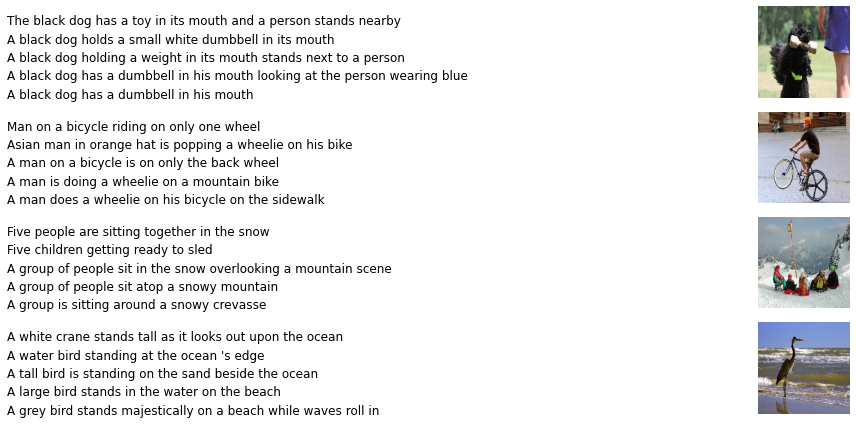

In [189]:
#Let Visualise the ABove statemet of each image has 5 caption by Visualising both the images & text in Datasets

fig = plt.figure(figsize=(15,6)) # Setting figsize for proper readability
count = 1

for imag_path in df[-26:-11].Path.unique(): # selecting the paths of first 6 distinct images
    captions = list(df["Captions"].loc[df.Path == imag_path].values)
    caption_image = tf.keras.utils.load_img(imag_path,target_size=(180,180,2))

    ax = fig.add_subplot(4,2,count) # creating subplots of 6 rows
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))

    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=12)  # selecting the captions fontsize
    count+=1
    plt.tight_layout() #For automatically adjust subplot parameters we give specified padding to it.

    ax = fig.add_subplot(4,2,count)
    ax.imshow(caption_image)
    plt.axis('off') #we does not require axes because we are only intrested to visualise the image  with captions
    count +=1

plt.show()

In [190]:
# Let do some Normalizing of text data i.e annotation
rem_punc = str.maketrans('', '', string.punctuation)
for txt in range(len(annotations)) :
    sent = annotations[txt]
    sent = line.split()
  # Let do Lowercasing and remove punctuation from each annotation and hanging letters and also remove numeric values in sent Vars
    sent = [word.lower() for word in sent]
    sent = [word.translate(rem_punc) for word in sent]     # Remove punctuation                (character you want to replace) (corresponding characters for substitution)  remove punc characters from text (delete chars from text - 3rd input)
    sent = [word for word in sent if len(word) > 1]
    sent = [word for word in sent if word.isalpha()]

    annotations[txt] = ' '.join(sent)

In [191]:
#Create a list which contains all the captions
#add the <start> & <end> token to all those captions as well
annotations = ['<start> '+ annoted_caption + ' <end>' for annoted_caption in df.Captions]   # IT contain <start> & <end> token with caption in between of it.
all_img_path = all_img_vector #It store the unique path to avoid duplicate path as there may be duplicate images
#all_img_path

In [192]:
print(f"Total captions present in the dataset: {str(len(annotations))}")
print(f"Total images present in the dataset: {str(len(all_img_path))}")

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


In [193]:
#Create the vocabulary & the counter for the captions

vocabulary= [] # empty list
for i in df['Captions']:
    for j in i.lower().split():
        vocabulary.append(j)  # This append all the values of captions after lowercasing and splitting it, And append to vocabulary Vars
val_count=Counter(vocabulary)
val_count # Let see what inside  in val_count Vars

Counter({'a': 60196,
         'child': 1507,
         'in': 18174,
         'pink': 702,
         'dress': 332,
         'is': 9069,
         'climbing': 490,
         'up': 1215,
         'set': 105,
         'of': 6495,
         'stairs': 109,
         'an': 2325,
         'entry': 1,
         'way': 48,
         'girl': 3277,
         'going': 145,
         'into': 1046,
         'wooden': 278,
         'building': 485,
         'little': 1736,
         'playhouse': 6,
         'the': 17507,
         'to': 3005,
         'her': 1102,
         'cabin': 4,
         'black': 3620,
         'dog': 7948,
         'and': 8057,
         'spotted': 36,
         'are': 3365,
         'fighting': 130,
         'tri-colored': 12,
         'playing': 1954,
         'with': 7304,
         'each': 399,
         'other': 667,
         'on': 10357,
         'road': 380,
         'white': 3706,
         'brown': 2457,
         'spots': 28,
         'staring': 57,
         'at': 2810,
         'stree

In [194]:
#Let check out the top-30 stopwords with higher ouccurance word in caption
#wordcloud = WordCloud(width = 500, height = 100).generate_from_frequencies(val_count)
#plt.figure(figsize = (15, 6))
#plt.imshow(wordcloud)


Text(0, 0.5, 'Count')

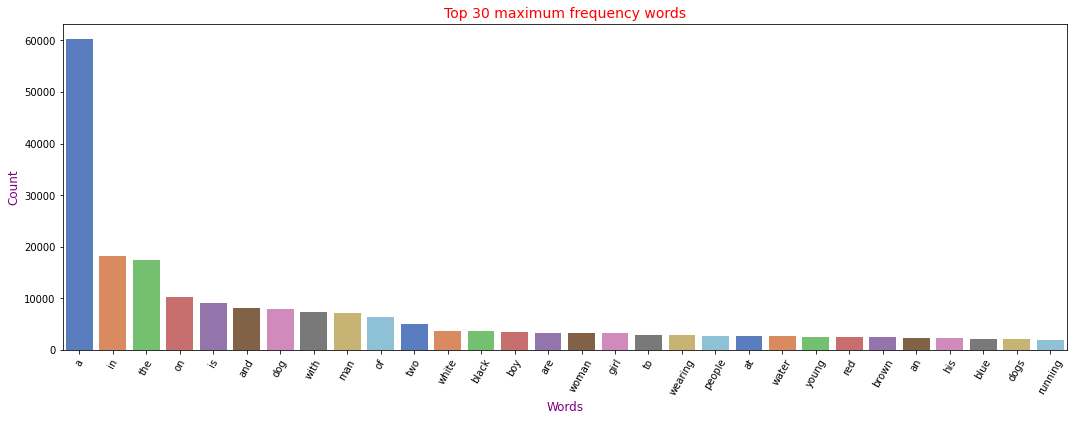

In [195]:
#Visualise the top 30 occuring words in the captions
Top_30= val_count.most_common(30) # It store the 30 most commomly occuring word in val_count Vars
Top_30_df = pd.DataFrame(Top_30, columns = ['Word', 'Count']) # It store Top_30 higer frequnecy word & count in dataframe for plotting
# figure
plt.figure(figsize = (18, 6))
# Let use seaborn and plot bar graph between word on x-axis and count on y-axis
sns.barplot(x='Word', y='Count',data=Top_30_df,palette="muted")

plt.title("Top 30 maximum frequency words", fontsize = 14, color= 'red')
plt.xlabel("Words", fontsize = 12, color= 'purple')
plt.xticks(rotation=60)
plt.ylabel("Count", fontsize = 12, color= 'purple')

## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters.
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [196]:
print(annotations[0:5]) # Let re-view the annotation/captions before pre-processing of Captions

['<start> A child in a pink dress is climbing up a set of stairs in an entry way  <end>', '<start> A girl going into a wooden building  <end>', '<start> A little girl climbing into a wooden playhouse  <end>', '<start> A little girl climbing the stairs to her playhouse  <end>', '<start> A little girl in a pink dress going into a wooden cabin  <end>']


In [197]:
# create the tokenizer
num_word = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=num_word,
                     filters='!"#$%^&*()_+.,:;-?/~`{}[]|\=@ ',#'!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n',
                     lower=True,
                     split=' ',
                     char_level=False,
                     oov_token="<unk>") #Replace all other words with the unknown token "UNK" .

# Create word-to-index and index-to-word mappings.
tokenizer.fit_on_texts(annotations)
# convert to sequence of integers for training
train_sequence = tokenizer.texts_to_sequences(annotations)
# Pading the tokenize word
tokenizer.word_index['PAD'] = 0 # we add PAD token for zero
tokenizer.index_word[0] = 'PAD'

Resons for Padding-->
- Each individual image has five captions which are all of different lengths. Hence they can't be fed directly to the Decoder.

- We will use PADDING, to bring all captions(of diffrent lenght) to a fixed or similar length before proceeding further.

- Padding is a process that we apply at the start or the end of a sequence to make all the samples to have a common standard length.

- Pading is also use in matrix in deep learning

In [198]:
tokenizer.word_index['<start>']
tokenizer.word_index['<end>']
#print(tokenizer.oov_token)
#print(tokenizer.index_word[0])

4

In [199]:
# let also see what inside of train_sequence look like
print('train_sequence',train_sequence[:5])

train_sequence [[3, 2, 44, 5, 2, 89, 173, 8, 116, 52, 2, 389, 13, 385, 5, 29, 1, 670, 4], [3, 2, 20, 313, 64, 2, 197, 120, 4], [3, 2, 39, 20, 116, 64, 2, 197, 2368, 4], [3, 2, 39, 20, 116, 6, 385, 21, 63, 2368, 4], [3, 2, 39, 20, 5, 2, 89, 173, 313, 64, 2, 197, 2887, 4]]


Text(0, 0.5, 'Count')

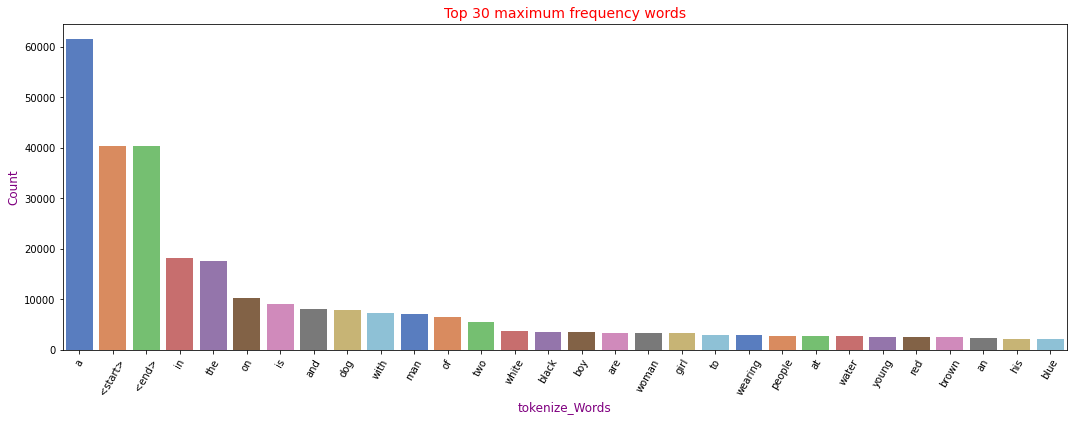

In [200]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing
tokenizer_wor_counts = Counter(tokenizer.word_counts) # creating list of tokenize word and its counts
top30_tokenizer_W_df = pd.DataFrame(tokenizer_wor_counts.most_common(30), columns=['words', 'count']) # making dataframe of top 30 occuring tokenise word via frequency ofword
plt.figure(figsize=(18,6))
top30_plot = sns.barplot(x='words', y='count', data=top30_tokenizer_W_df,palette="muted")
plt.title("Top 30 maximum frequency words", fontsize = 14, color= 'red')
plt.xlabel("tokenize_Words", fontsize = 12, color= 'purple')
plt.xticks(rotation=60)
plt.ylabel("Count", fontsize = 12, color= 'purple')

In [201]:
# Pad each vector to the max_length of the captions ^ store it to a vairable
max_seq = max([len(x) for x in train_sequence])

cap_vector= tf.keras.preprocessing.sequence.pad_sequences(train_sequence,
                                                          padding='post')#,
                                                       #   maxlen=max_seq,
                                                        #  value=0)

print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40455, 35)


## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3.

### FAQs on how to resize the images::
* Since you have a list which contains all the image path, you need to first convert them to a dataset using <i>tf.data.Dataset.from_tensor_slices</i>. Once you have created a dataset consisting of image paths, you need to apply a function to the dataset which will apply the necessary preprocessing to each image.
* This function should resize them and also should do the necessary preprocessing that it is in correct format for InceptionV3.


In [202]:
#write your code here to create the dataset consisting of image paths
image_dataset = image_dataset = tf.data.Dataset.from_tensor_slices(all_img_path)
IMAGE_SHAPE = (299, 299)

In [203]:
# let see what's inside image_dataset
[i for i in image_dataset][:5]

[<tf.Tensor: shape=(), dtype=string, numpy=b'./flickr8k/Images/1000268201_693b08cb0e.jpg'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'./flickr8k/Images/1000268201_693b08cb0e.jpg'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'./flickr8k/Images/1000268201_693b08cb0e.jpg'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'./flickr8k/Images/1000268201_693b08cb0e.jpg'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'./flickr8k/Images/1000268201_693b08cb0e.jpg'>]

In [204]:
#write your code here for creating the function. This function should return images & their path
def load_image(image_path):
    #write your pre-processing steps here
    img = tf.io.read_file(image_path, name=None)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SHAPE)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [205]:
#applying the function to the image path dataset, such that the transformed dataset should contain images & their path
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# we are keeping batch size as 64 and setting drop_remainder to False so not to drop a batch
# if it contains elements less than 64
#batch dataset
image_dataset = image_dataset.batch(64,drop_remainder=False)
# print the resized image dataset
image_dataset

<BatchDataset shapes: ((None, 299, 299, 3), (None,)), types: (tf.float32, tf.string)>

In [206]:
#batch dataset
#image_dataset = image_dataset.batch(8, drop_remainder=False)
#image_dataset

In [207]:
# normalizing image & slicing dataset
# Get unique images
# encode_train = sorted(set(all_img_path))
#image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)

#Images will be resized to (299,299,3) and will be normalized
#image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(64)

# print the resized image dataset
#image_dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


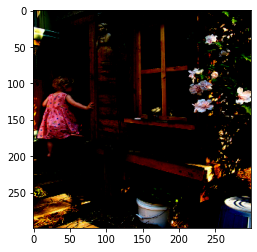

In [208]:
plt.imshow(load_image(all_img_path[0])[0])

## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of the images using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048.

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [209]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')


new_input = image_model.input # get the input of the image_model
hidden_layer = image_model.layers[-1].output # get the output of the image_model

image_features_extract_model = tf.compat.v1.keras.Model(new_input, hidden_layer) #build the final model using both input & output layer

In [210]:
#print model summary
image_features_extract_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_94 (Conv2D)             (None, None, None,   864         ['input_2[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization_94 (BatchN  (None, None, None,   96         ['conv2d_94[0][0]']              
 ormalization)                  32)                                                         

In [211]:
# write the code to apply the feature_extraction model to your earlier created dataset which contained images & their respective paths
# How To store the features of extracted image by using a dictionary with the path as the key and values as the feature extracted through InceptionV3 model
imag_features={}
for img, img_path in tqdm(image_dataset): # for displaying progress we use tqdm lib.
    batch_features = image_features_extract_model(img) # extracting features from images
    batch_features_f = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3])) #flattening the image to reduce space occupancy into batch_features_f
    for batch_f, path in zip(batch_features_f, img_path) :
        feature_path = path.numpy().decode('utf-8')
        imag_features[feature_path] = batch_f.numpy()
#imag_feature

100%|██████████| 633/633 [02:15<00:00,  4.68it/s]


In [212]:
batch_features_f

<tf.Tensor: shape=(7, 64, 2048), dtype=float32, numpy=
array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 1.73496112e-01, 1.48768771e+00, ...,
         8.37395310e-01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 2.98368573e-01, 6.34110630e-01, ...,
         7.08046317e-01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.15718335e-01, ...,
         4.39519912e-01, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.0

In [213]:
batch_features

<tf.Tensor: shape=(7, 8, 8, 2048), dtype=float32, numpy=
array([[[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [3.97453398e-01, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[0.00000000e+00, 6.35464251e-01, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 1.30200163e-02],
         [0.00000000e+00, 6.84833378e-02, 0.00000000e+00, ...,
          

In [214]:
len(imag_features)

8091

In [215]:
batch_f.shape

TensorShape([64, 2048])

### FAQs on how to store the features:
* You can store the features using a dictionary with the path as the key and values as the feature extracted by the inception net v3 model OR
* You can store using numpy(np.save) to store the resulting vector.

## Dataset creation
1.Apply train_test_split on both image path & captions to create the train & test list. Create the train-test spliit using 80-20 ratio & random state = 42

2.Create a function which maps the image path to their feature.

3.Create a builder function to create train & test dataset & apply the function created earlier to transform the dataset

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 8*8, 2048)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [216]:
#Apply train_test_split on both image path & captions to create the train & test list. Create the train-test spliit using 80-20 ratio & random state = 42
path_train, path_test, cap_train, cap_test = train_test_split(all_img_path, cap_vector, test_size=0.2, random_state=42)

In [217]:
print('img_name_train, cap_train, img_name_val, cap_val',len(path_train), len(cap_train), len(path_test), len(cap_test))
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

img_name_train, cap_train, img_name_val, cap_val 32364 32364 8091 8091
Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


In [218]:
# Create a function which maps the image path to their feature.
# This function will take the image_path & caption and return it's feature & respective caption.

def map_func(image_name,caption):
    img_tensor = imag_features[image_name.decode('utf-8')]
    return img_tensor, caption

### FAQs on how to load the features:
* You can load the features using the dictionary created earlier OR
* You can store using numpy(np.load) to load the feature vector.

In [219]:
# create a builder function to create dataset which takes in the image path & captions as input
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier

BATCH_SIZE=64 
BUFFER_SIZE=2000
def gen_dataset(img_data,cap_data):
    dataset = tf.data.Dataset.from_tensor_slices((img_data,cap_data))
    dataset = dataset.map(lambda x, y: tf.numpy_function(map_func, [x, y], [tf.float32, tf.int32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(BATCH_SIZE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
       
    return dataset



In [220]:
train_dataset=gen_dataset(path_train,cap_train)
test_dataset=gen_dataset(path_test,cap_test)

In [221]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

(64, 64, 2048)
(64, 35)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [222]:
embedding_dim = 256 
units = 512
vocab_size = 5001 #top 5,000 words +1
train_num_steps = len(path_train) // BATCH_SIZE #len(total train images) // BATCH_SIZE
test_num_steps = len(path_test) // BATCH_SIZE #len(total test images) // BATCH_SIZE
max_length = 31
feature_shape = batch_f.shape[1]
attention_feature_shape = batch_f.shape[0]

In [223]:
#print(tf.compat.v1.get_default_graph())

### Encoder

In [224]:
# Encoder-CNN
#Building Encoder using CNN Keras subclassing method
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim) #build your Dense layer with relu activation
        
    def call(self, features):
        features =  self.dense(features) # extract the features from the image shape: (batch, 8*8, embed_dim)
        features =  tf.keras.activations.relu(features, alpha=0.01, max_value=None, threshold=0)
        return features

In [225]:
encoder=Encoder(embedding_dim)

In [226]:
# Let plot the model by keras utils.vis by plot model
#from keras.utils.vis_utils import plot_model
#plot_model(encoder, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Attention model

In [227]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units) #build your Dense layer
        self.W2 = tf.keras.layers.Dense(units) #build your Dense layer
        self.V = tf.keras.layers.Dense(1) #build your final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        # features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)#hidden[:, tf.newaxis]
        # build your score funciton to shape: (batch_size, 8*8, units)
        score = tf.keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis))  
        # extract your attention weights with shape: (batch_size, 8*8, 1)
        attention_weights = tf.keras.activations.softmax(self.V(score), axis=1) 
        #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = attention_weights * features 
        # reduce the shape to (batch_size, embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1)  
        
        return context_vector, attention_weights

### Decoder

In [228]:
#RNN - Model (GRU)
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units) #iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim,mask_zero=False)#build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units) #build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size) #build your Dense layer
        

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden) #create your context vector & attention weights from attention model
        embed = self.embed(x) # embed your input to shape: (batch_size, 1, embedding_dim)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis = -1) # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed) # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        
        return output, state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))
    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [229]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [230]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (64, 64, 256)
Predcitions shape from Decoder: (64, 5001)
Attention weights shape from Decoder: (64, 64, 1)


In [231]:
# let see summary of encoder based CNN model
encoder.summary() #

Model: "encoder_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            multiple                  524544    
                                                                 
Total params: 524,544
Trainable params: 524,544
Non-trainable params: 0
_________________________________________________________________


In [232]:
# let see summary of decoder based RNN model
decoder.summary() #

Model: "decoder_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 attention_model_5 (Attentio  multiple                 394753    
 n_model)                                                        
                                                                 
 embedding_5 (Embedding)     multiple                  1280256   
                                                                 
 gru_5 (GRU)                 multiple                  1575936   
                                                                 
 dense_30 (Dense)            multiple                  262656    
                                                                 
 dense_31 (Dense)            multiple                  2565513   
                                                                 
Total params: 6,079,114
Trainable params: 6,079,114
Non-trainable params: 0
_______________________________________________

## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [233]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)  #alt-->tf.keras.optimizers.RMSprop(learning_rate=0.0005,momentum=0.001)#define the optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = tf.keras.losses.Reduction.NONE) #define your loss object

In [234]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [235]:
checkpoint_path = "Flickr8K/checkpoint"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [236]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

* While creating the training step for your model, you will apply Teacher forcing.
* Teacher forcing is a technique where the target/real word is passed as the next input to the decoder instead of previous prediciton.

In [237]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.reset_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        
        #write your code here to do the training steps
        encoded_data = encoder(img_tensor)
        for x in range(1,target.shape[1]):
            pred, hidden, _ = decoder(dec_input, encoded_data, hidden)
            loss += loss_function(target[:, x], pred)
            dec_input = tf.expand_dims(target[:,x], 1)
        avg_loss = (loss/int(target.shape[1])) #avg loss for every batch
        trainable_vars = encoder.trainable_variables + decoder.trainable_variables #all trainable variables for which gradient should be calculated
        gradients = tape.gradient(loss,trainable_vars) #calculating the new gradients
        optimizer.apply_gradients(zip(gradients, trainable_vars))  
    return loss, avg_loss

* While creating the test step for your model, you will pass your previous prediciton as the next input to the decoder.

In [238]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        encoder_output = encoder(img_tensor)
        for x in range(1,target.shape[1]):
            pred, hidden, _ = decoder(dec_input, encoder_output, hidden)
            loss += loss_function(target[:,x], pred) #updating the loss function
            predicted_id = tf.argmax(pred,1)
            dec_input = tf.expand_dims(predicted_id, 1) #input to decoder, as there is no teacher function

        avg_loss = (loss/int(target.shape[1]))
    
        trainable_vars = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient (loss, trainable_vars) # calculating gradient wrt each trainable var
        optimizer.apply_gradients(zip(gradients, trainable_vars))
        
    return loss, avg_loss

In [239]:
def test_loss_cal(test_dataset):
    total_loss = 0

    #write your code to get the average loss result on your test data
    for (batch, (img_tensor, target)) in enumerate(test_dataset) :
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss = total_loss + t_loss
        avg_test_loss = total_loss/ test_num_steps

    return avg_test_loss

In [240]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps

    loss_plot.append(avg_train_loss)
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)

    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/15 [00:00<?, ?it/s]

For epoch: 1, the train loss is 1.376, & test loss is 1.528
Time taken for 1 epoch 208.17185306549072 sec

Test loss has been reduced from 100.000 to 1.528


  7%|▋         | 1/15 [03:28<48:37, 208.39s/it]

For epoch: 2, the train loss is 1.064, & test loss is 1.450
Time taken for 1 epoch 96.0167486667633 sec

Test loss has been reduced from 1.528 to 1.450


 13%|█▎        | 2/15 [05:04<30:51, 142.41s/it]

For epoch: 3, the train loss is 0.965, & test loss is 1.400
Time taken for 1 epoch 96.7912974357605 sec

Test loss has been reduced from 1.450 to 1.400


 20%|██        | 3/15 [06:41<24:20, 121.69s/it]

For epoch: 4, the train loss is 0.897, & test loss is 1.365
Time taken for 1 epoch 95.5886869430542 sec

Test loss has been reduced from 1.400 to 1.365


 27%|██▋       | 4/15 [08:17<20:26, 111.49s/it]

For epoch: 5, the train loss is 0.843, & test loss is 1.331
Time taken for 1 epoch 92.21635103225708 sec

Test loss has been reduced from 1.365 to 1.331


 33%|███▎      | 5/15 [09:49<17:26, 104.62s/it]

For epoch: 6, the train loss is 0.794, & test loss is 1.307
Time taken for 1 epoch 92.55082488059998 sec

Test loss has been reduced from 1.331 to 1.307


 40%|████      | 6/15 [11:22<15:05, 100.61s/it]

For epoch: 7, the train loss is 0.753, & test loss is 1.287
Time taken for 1 epoch 95.53603768348694 sec

Test loss has been reduced from 1.307 to 1.287


 47%|████▋     | 7/15 [12:58<13:12, 99.02s/it] 

For epoch: 8, the train loss is 0.715, & test loss is 1.269
Time taken for 1 epoch 95.87857818603516 sec

Test loss has been reduced from 1.287 to 1.269


 53%|█████▎    | 8/15 [14:34<11:26, 98.10s/it]

For epoch: 9, the train loss is 0.682, & test loss is 1.248
Time taken for 1 epoch 96.39390230178833 sec

Test loss has been reduced from 1.269 to 1.248


 60%|██████    | 9/15 [16:11<09:45, 97.64s/it]

For epoch: 10, the train loss is 0.654, & test loss is 1.233
Time taken for 1 epoch 95.9030978679657 sec

Test loss has been reduced from 1.248 to 1.233


 67%|██████▋   | 10/15 [17:47<08:05, 97.18s/it]

For epoch: 11, the train loss is 0.629, & test loss is 1.216
Time taken for 1 epoch 93.0521297454834 sec

Test loss has been reduced from 1.233 to 1.216


 73%|███████▎  | 11/15 [19:20<06:24, 96.01s/it]

For epoch: 12, the train loss is 0.605, & test loss is 1.208
Time taken for 1 epoch 96.41068625450134 sec

Test loss has been reduced from 1.216 to 1.208


 80%|████████  | 12/15 [20:57<04:48, 96.22s/it]

For epoch: 13, the train loss is 0.584, & test loss is 1.206
Time taken for 1 epoch 92.72014045715332 sec

Test loss has been reduced from 1.208 to 1.206


 87%|████████▋ | 13/15 [22:30<03:10, 95.24s/it]

For epoch: 14, the train loss is 0.568, & test loss is 1.200
Time taken for 1 epoch 92.64221167564392 sec

Test loss has been reduced from 1.206 to 1.200


 93%|█████████▎| 14/15 [24:03<01:34, 94.54s/it]

For epoch: 15, the train loss is 0.548, & test loss is 1.192
Time taken for 1 epoch 92.56579756736755 sec

Test loss has been reduced from 1.200 to 1.192


100%|██████████| 15/15 [25:36<00:00, 102.42s/it]


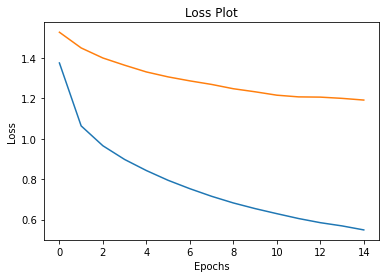

In [270]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

#### NOTE:
* Since there is a difference between the train & test steps ( Presence of teacher forcing), you may observe that the train loss is decreasing while your test loss is not.
* This doesn't mean that the model is overfitting, as we can't compare the train & test results here, as both approach is different.
* Also, if you want to achieve better results you can run it more epochs, but the intent of this capstone is to give you an idea on how to integrate attention mechanism with E-D architecture for images. The intent is not to create the state of art model.

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [315]:
def evaluate(image):
    
    attention_plot = np.zeros((31, attention_feature_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input) # Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val) # extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(31):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden) # get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy() #extract the predicted id(embedded value) which carries the max value
        #map the id to the word from tokenizer and append the value to the result list
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions



### Beam Search(optional)

In [316]:
# Define Evaluation function which uses Beam Search Algorithm
# OPTIONAL
#def beam_evaluate(image, beam_index=3):
   # start = [tokenizer.word_index['<start>']]
   # result = [[start, 0.0]]
    
  #  attention_plot = np.zeros((max_length, attention_feature_shape))
    
 #   hidden = decoder.reset_state(batch_size=1)
    
   # temp_input = tf.expand_dims(load_image(image)[0], 0)
   # img_tensor_val = image_features_extract_model(temp_input)
   # img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
    
   # features = encoder(img_tensor_val)

   # dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    
   # while len(result[0][0]) < max_length:
      #  temp = []
      #  i = 0
       # for s in result:
          #  predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
           # attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
           # i = i+1
           #word_preds = np.argsort(predictions[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
           # for w in word_preds:
          #      next_cap, prob = s[0][:], s[1]
           #     next_cap.append(w)
            #    prob += np.log(predictions[0][w])
            #    temp.append([next_cap, prob])
                    
       # result = temp
        # Sorting according to the probabilities
        #result = sorted(result, reverse=False, key=lambda l: l[1])
        # Getting the top words
       # result = result[-beam_index:]
    
        #predicted_id = result[-1]
       # pred_list = predicted_id[0]
       
       # prd_id = pred_list[-1] 
         
        #if(prd_id!=4):
           # dec_input = tf.expand_dims([prd_id], 0)  
      #  else:
       #     break
     #   
   # result = result[-1][0]
    
   # intermediate_caption = [tokenizer.index_word[i] for i in result]
   # final_caption = []
    
   # for i in intermediate_caption:
     #   if i != '<end>':
     #       final_caption.append(i)
     #   else:
      #      break
#
   # attention_plot = attention_plot[:len(final_caption), :]
    #final_caption = ' '.join(final_caption[1:])
  #  return final_caption,attention_plot



In [317]:

def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))

    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))

        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)

        img=ax.imshow(temp_img)

        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

#### evaluation

In [318]:
#from nltk.translate.bleu_score import sentence_bleu

In [319]:
def filt_text(text):
    filt=['<start>','<unk>','<end>']
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

BELU score: 25.0
Real Caption: two dogs
Prediction Caption: two dogs with looking away jumping a owners


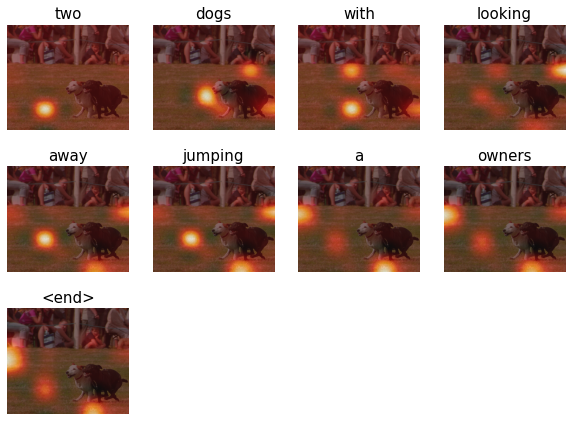

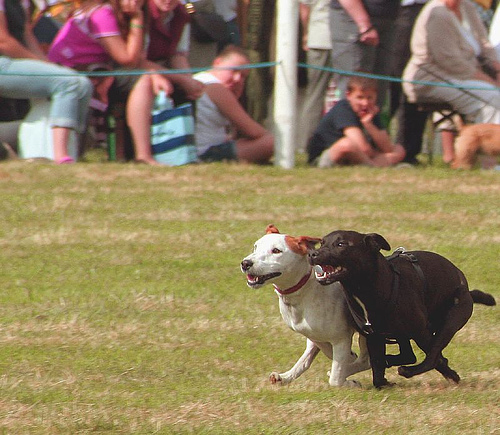

In [320]:
rid = np.random.randint(0, len(path_test))
test_image = path_test[rid]
#test_image = './images/413231421_43833a11f5.jpg'
#real_caption = '<start> black dog is digging in the snow <end>'

real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)


real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))#set your weights
print(f"BELU score: {score*100}")

print('Real Caption:', real_caption)
print('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)

BELU score: 23.076923076923077
Real Caption: a football player kicks the ball
Prediction Caption: a player tries field uniform holding kicks a is down a dribbles down


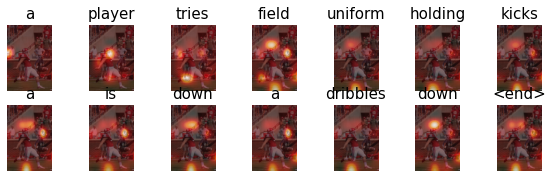

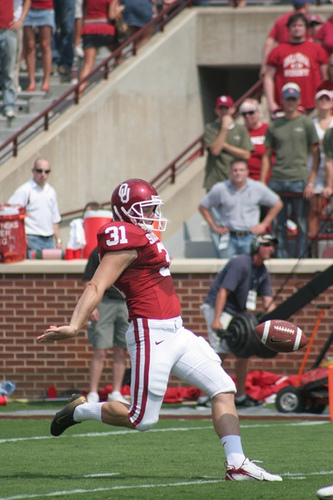

In [321]:
rid = np.random.randint(0, len(path_test))
test_image = path_test[rid]
#test_image = './images/413231421_43833a11f5.jpg'
#real_caption = '<start> black dog is digging in the snow <end>'

real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)


real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))#set your weights
print(f"BELU score: {score*100}")

print('Real Caption:', real_caption)
print('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)

In [322]:
 #OPtional Beam
#captions=beam_evaluate(test_image)
#print(captions)

 # Part -2:Captions to Audio(speech)
 - Through text-to speech API

In [323]:
!pip install gTTS #Google Translate text-to-speech API


In [324]:
def pred_caption_audio(random, autoplay=False, weights=(0.5, 0.5, 0, 0)) :

    cap_test_data = cap_test.copy()
    rid = np.random.randint(0, random)
    test_image = path_test[rid]
    #test_image = './images/413231421_43833a11f5.jpg'
    #real_caption = '<start> black dog is digging in the snow <end>'

    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test_data[rid] if i not in [0]])
    result, attention_plot, pred_test = evaluate(test_image)


    real_caption=filt_text(real_caption)      


    pred_caption=' '.join(result).rsplit(' ', 1)[0]


    real_appn = []
    real_appn.append(real_caption.split())
    reference = real_appn
    candidate = pred_caption.split()

    score = sentence_bleu(reference, candidate, weights=weights)#set your weights
    print(f"BELU score: {score*100}")
    print ('Real Caption:', real_caption)
    print ('Prediction Caption:', pred_caption)
    plot_attmap(result, attention_plot, test_image)

    # we will make use of Google Text to Speech API (online), which will convert the caption to audio
    speech = gTTS('Predicted Caption : ' + pred_caption, lang = 'en', slow = False)
    speech.save('voice.mp3')
    audio_file = 'voice.mp3'

    display.display(display.Audio(audio_file, rate = None, autoplay = autoplay))

    return test_image

In [325]:
# Required libraries
from gtts import gTTS
from IPython import display

### Model Tests using Greedy Search with Audio:

BELU score: 75.98356856515926
Real Caption: a man and woman setup a camera
Prediction Caption: a man for the photograph camera adjust in tripod


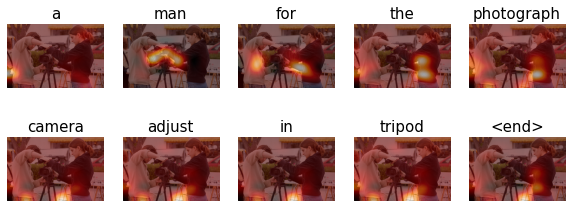

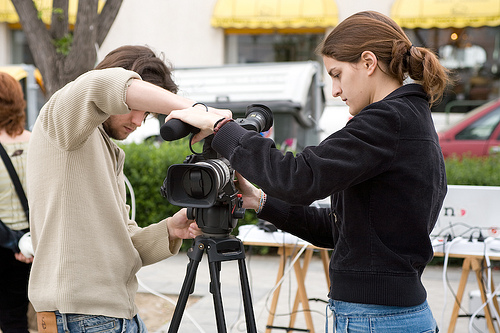

In [435]:
test_image = pred_caption_audio(len(path_test), True, weights = (0.25, 0, 0, 0))
Image.open(test_image)

BELU score: 27.234999566941156
Real Caption: a little girl in a pink jacket throwing some leafs up in the air
Prediction Caption: a child in a fence in pants leaning upside through a coat from playing a the as begins pink


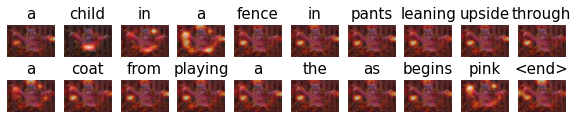

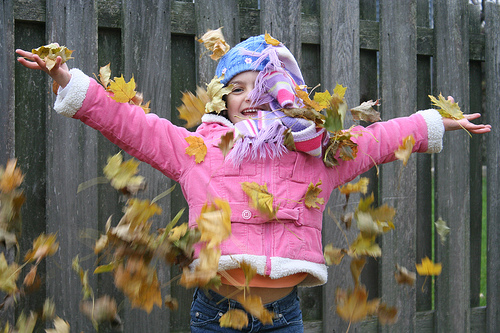

In [421]:
test_image = pred_caption_audio(len(path_test), True, weights = (0, 0.45, 0, 0))
Image.open(test_image)

BELU score: 2.9476022969691995e-60
Real Caption: a child wearing blue and white shorts is jumping in the surf
Prediction Caption: a child splashes jumping white board puddle watches body bucket a the the


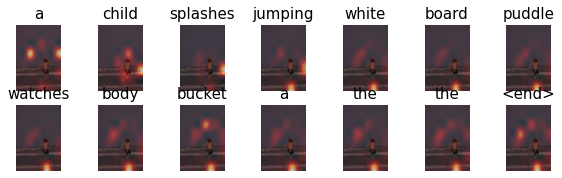

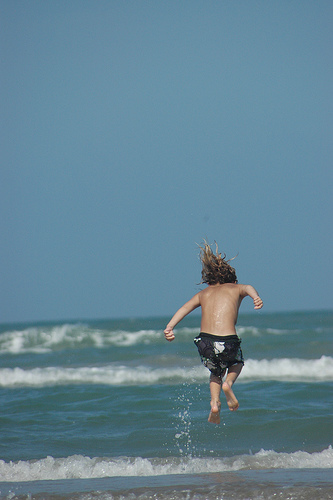

In [415]:
test_image = pred_caption_audio(len(path_test), True, weights = (0,0, 0.2, 0))
Image.open(test_image)

BELU score: 8.013616352889868e-76
Real Caption: a girl is getting ready to swing the club
Prediction Caption: the man pointing pigtails bathroom a shirt of is a


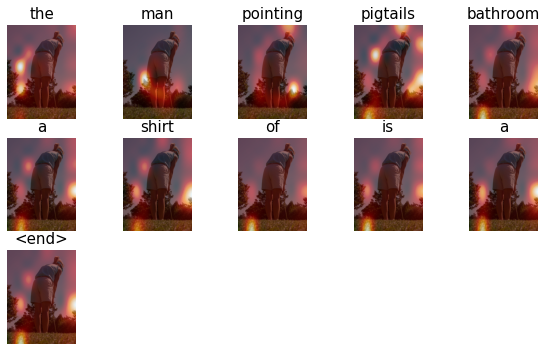

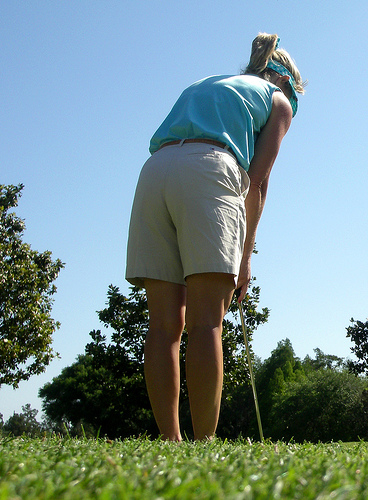

In [329]:
test_image = pred_caption_audio(len(path_test), True, weights = (0.35, 0.25, 0, 0))
Image.open(test_image)

BELU score: 1.9587741630036196e-06
Real Caption: a man walks through an arcade
Prediction Caption: busy walks of a busy city


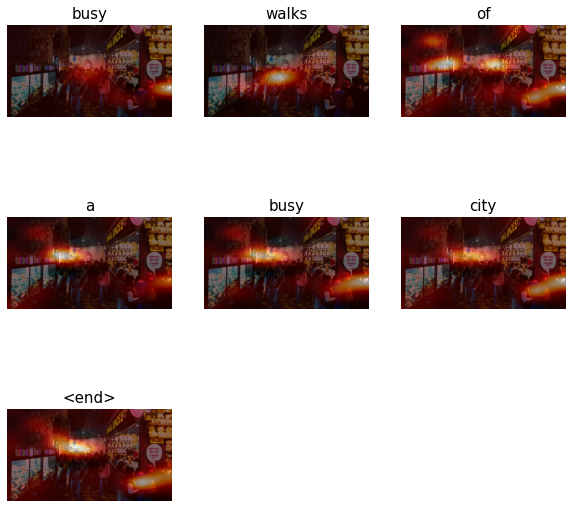

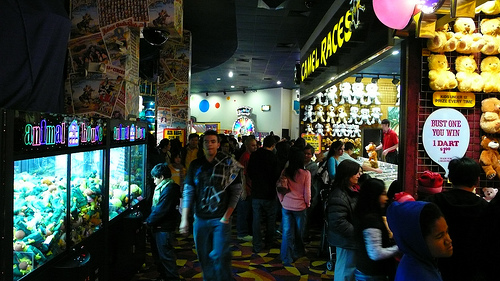

In [409]:
test_image = pred_caption_audio(len(path_test), True, weights = (0.035, 0.025, 0.0, 0.0))
Image.open(test_image)

BELU score: 85.71796599217684
Real Caption: a skier is throwing up snow as he skis off piste
Prediction Caption: a skier skiing side a to mountain steep snow picture skiing


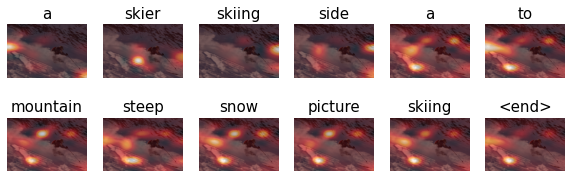

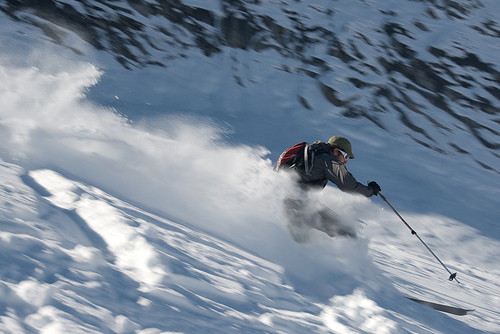

In [402]:
test_image = pred_caption_audio(len(path_test), True, weights = (0.03,0.05,0, 0))
Image.open(test_image)

BELU score: 3.788433419367645e-14
Real Caption: a little girl jumps in the air next to a jukebox mural
Prediction Caption: a girl leaps from by a building jukebox front jukebox front of in jukebox on barb tank tall playing around front of front car jukebox of building truck door jukebox


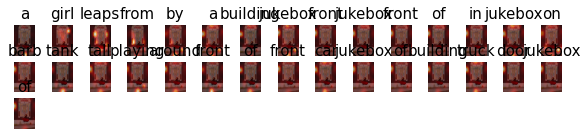

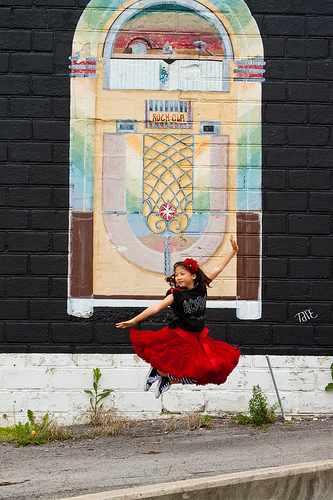

In [391]:
test_image = pred_caption_audio(len(path_test), True, weights = (0.05,0.05,0, 0))
Image.open(test_image)

BELU score: 100.0
Real Caption: girls dressed in red and black costumes hold a wrestling pose
Prediction Caption: little girls in black a girl a fancy others for a wrestling is are wrestling on


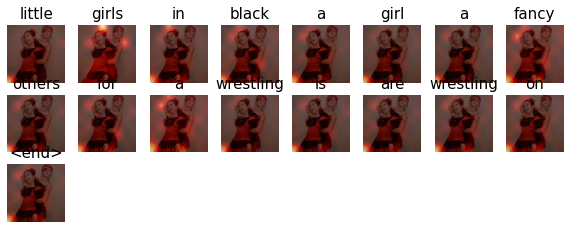

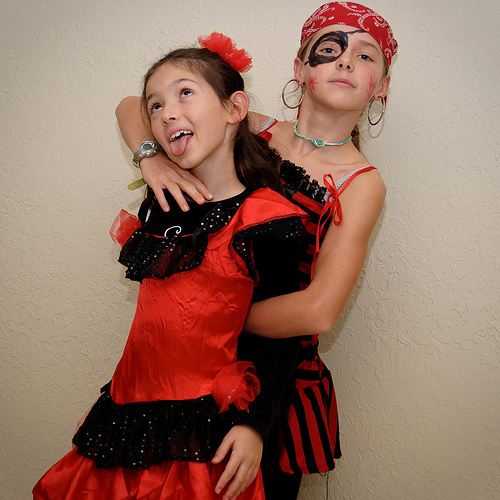

In [399]:
test_image = pred_caption_audio(len(path_test), True, weights = (0,0.0,0, 0))
Image.open(test_image)

BELU score: 3.3041287684950983e-214
Real Caption: a baby in crawls on a clean hardwood floor
Prediction Caption: a small child setting crawls a floor


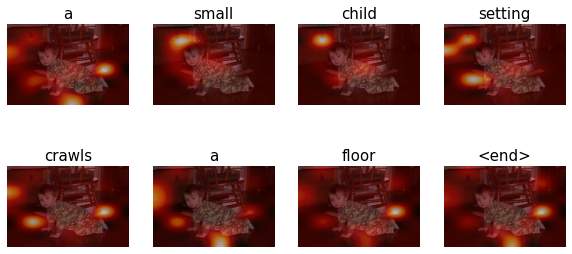

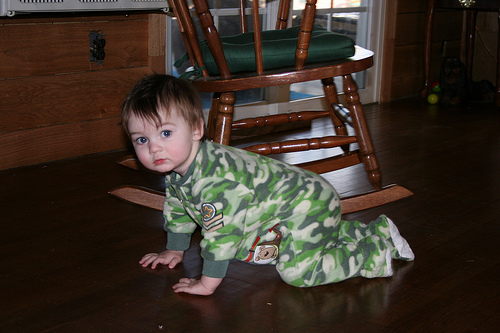

In [450]:
test_image = pred_caption_audio(len(path_test), True, weights = (0,0,0,0.7))
Image.open(test_image)

## Conculsion:

The capstone project utilized a limited Flickr8K dataset, training on only 80% of approximately 6500 images. Despite resource and time constraints, the model functions adequately with most test dataset images, indicating room for improvement.

Improvements for Caption Generation:

• Generated captions may lack meaning and well-formed sentences.

• Repeated words or words may be repeated in captions, especially in beam search results.

• Color recognition may not be accurate in some images.

• Attention plot may fail with errors when captions are only two words

Future Improvements for Model Accuracy
• Use advanced Attention models like Multiheaded, Adaptive Attention with Visual Sentinel, and Semantic Attention.

• Implement Transformer-based models for better results than GRU.

• Try models other than Inception V3 for image feature extractions.

• Perform exhaustive hyper-parameter tuning.

Key point of Model Integration and Prediction:

• Focused on understanding how to integrate attention mechanism with E-D architecture for images.

• Prediction of captions based on word probabilities in vocabulary.

• Greedy Search calculated word probability based on occurrence in vocabulary list.

• BLUE Score used to evaluate model performance and accuracy.

• Model tes